In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

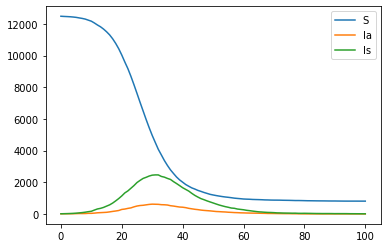

In [4]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

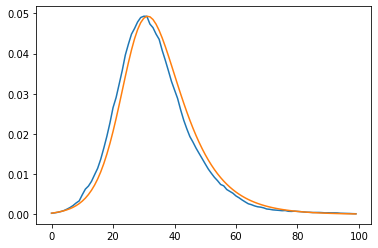

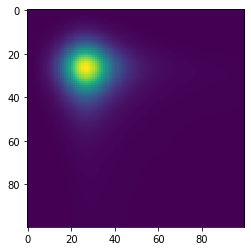

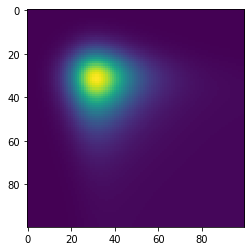

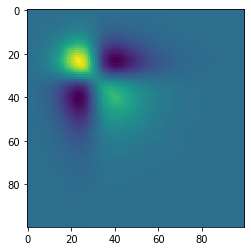

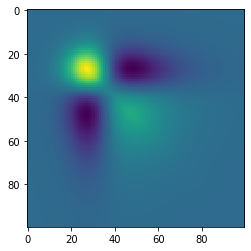

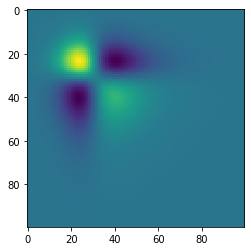

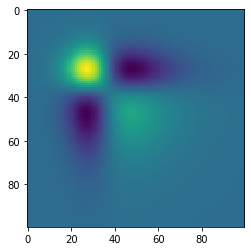

In [5]:
# load the data and rescale to intensive variables 
Tf = 100 # can truncate later 
Nf = Tf+1

x = np.load('sto_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

fltr=np.repeat(np.array([False, False, True]), 2)
obs=x[:, fltr] # need to full obs for inference, don't change here 
x0=x[0]

# estimate mean and cov 
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
xm,full_cov = estimator.obtain_full_mean_cov(x[0,:], Tf, Nf, det_model, contactMatrix)
full_cov = full_cov.todense()
plt.plot(x[1:,2*M])
plt.plot(xm[:,2*M])
plt.show()
for i in range(6):
    plt.imshow(full_cov[i::6,i::6])
    plt.show()

In [15]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-366.512862711605
1.1310088634490967


In [7]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 
alpha_g = 0.2
alpha_bounds = (0.1, 0.5)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.07
beta_bounds = (eps, 0.1)

gIa_g = 0.145
gIa_bounds = (eps, 0.5)

gIs_g = 0.145
gIs_bounds = (0.13, 0.15) 

fsa_g = 0.8

S0_g = S0/N
Ia0_g = Ia0/N

# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)  

# set up bounds for Ia and S 
bounds_for_Ia = [(0.1/N, 100/N)]*M
bounds_for_Is = [(6/N, 14/N)]*M 
bounds_for_S = [(fi[i]-100/N-Is0[i]/N, fi[i]-0.1/N) for i in range(M)]

# set up bounds for the rest of the params 
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0])
params = estimator.latent_inference(guess, obs, fltr, Tf, Nf, contactMatrix, 
                                    bounds, verbose=True, niter=2, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here 

parameters: [0.16713858 0.04702987 0.26165804 0.14007079]
parameters: [0.13356925 0.02356491 0.38082915 0.14004018]
parameters: [0.13324279 0.02325729 0.38203378 0.14010618]
parameters: [0.13197429 0.02187045 0.38686272 0.14046977]
parameters: [0.13192983 0.02158158 0.38721277 0.14060272]
parameters: [0.13243791 0.02124396 0.38596009 0.14090915]
parameters: [0.13412291 0.02102133 0.38117302 0.14151092]
parameters: [0.13707723 0.02125934 0.37285682 0.14257965]
parameters: [0.14211996 0.02166469 0.35877191 0.14448363]
parameters: [0.14945714 0.02235163 0.33831037 0.14725995]
parameters: [0.14903755 0.02223193 0.3395338  0.14712582]
parameters: [0.14944778 0.02222371 0.33842386 0.14729478]
parameters: [0.14986963 0.02222132 0.33727218 0.1474339 ]
parameters: [0.15039569 0.0222185  0.3358253  0.14754205]
parameters: [0.15196636 0.0222088  0.33149743 0.1477086 ]
parameters: [0.15420798 0.02218841 0.3253472  0.14769373]
parameters: [0.15679975 0.02213871 0.31830757 0.14725232]
parameters: [0

In [8]:
# save the parameters 
np.save('SIR_param.npy', params)

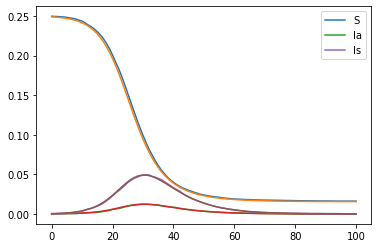

In [9]:
params = np.load('SIR_param.npy')
parameters = {'alpha':params[0], 'beta':params[1], 'gIa':params[2], 'gIs':params[3],'fsa':0.8}
estimator.set_params(parameters)
x0 = params[4:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

guessed initial conditons:  [12442 37443    22    15     6    13]
true initial conditions:  [12480. 37480.] [10 10] [10 10]


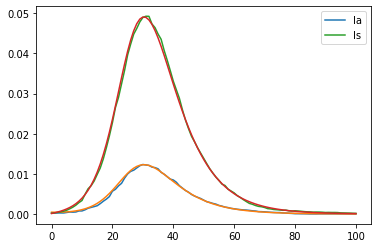

In [14]:
# replot the infected 
print('guessed initial conditons: ', (params[4:]*N).astype('int'))
print('true initial conditions: ', S0, Ia0, Is0)
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

In [18]:
hess = estimator.hessian_latent_params(params, obs[1:], fltr, Tf, Nf, contactMatrix)
print(hess)

[[ 2.28491298e+04 -4.50185909e+05  2.44090047e+03  1.60686582e+05]
 [-4.50185909e+05  5.97752266e+07 -2.60948750e+05 -3.04275389e+06]
 [ 2.44090047e+03 -2.60948750e+05  9.60185648e+02  1.67691682e+04]
 [ 1.60686582e+05 -3.04275389e+06  1.67691682e+04  1.15906826e+06]]


## Guess with smaller bounds on the parameters 

In [16]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 

alpha_g = 0.25 # better guess for alpha 
alpha_bounds = (0.15, 0.3) # better bounds on alpha 
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.07
beta_bounds = (eps, 0.1)

gIa_g = 0.145
gIa_bounds = (0.13, 0.15) # better bounds on gIa 

gIs_g = 0.145
gIs_bounds = (0.13, 0.15) 

fsa_g = 0.8

S0_g = S0/N
Ia0_g = Ia0/N

# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)  

# set up bounds for Ia and S 
bounds_for_Ia = [(0.1/N, 100/N)]*M
bounds_for_Is = [(6/N, 14/N)]*M 
bounds_for_S = [(fi[i]-100/N-Is0[i]/N, fi[i]-0.1/N) for i in range(M)]

# set up bounds for the rest of the params 
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0])
params = estimator.latent_inference(guess, obs, fltr, Tf, Nf, contactMatrix, 
                                    bounds, verbose=True, niter=2, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here 

parameters: [0.21715757 0.04704314 0.14664212 0.14007364]
parameters: [0.18357855 0.02357141 0.14832107 0.13847795]
parameters: [0.1821878  0.02246635 0.14838657 0.13861284]
parameters: [0.18108107 0.02150358 0.14844727 0.13877031]
parameters: [0.18020389 0.02061149 0.14850911 0.13896449]
parameters: [0.17986351 0.02007454 0.14855281 0.13912872]
parameters: [0.17999614 0.0198856  0.14857738 0.13925158]
parameters: [0.18123941 0.01960112 0.14865638 0.13974026]
parameters: [0.18322263 0.01971015 0.14873882 0.14050312]
parameters: [0.18596929 0.0198718  0.14885403 0.14161621]
parameters: [0.18958239 0.02020064 0.14898489 0.1431326 ]
parameters: [0.19170527 0.02037041 0.14904775 0.14401438]
parameters: [0.1916926  0.02032591 0.14904262 0.14398069]
basinhopping step 0: f -364.421
parameters: [0.28444914 0.0187564  0.13805925 0.14379409]
parameters: [0.28395763 0.01895061 0.13802037 0.14358125]
parameters: [0.28334578 0.01906958 0.13796091 0.14312245]
parameters: [0.28094335 0.01928012 0.137

In [17]:
# save the parameters 
np.save('SIR_param2.npy', params)

{'alpha': 0.20251896785152315, 'beta': 0.0200860845202662, 'gIa': 0.14688346413537623, 'gIs': 0.14231323781700606, 'fsa': 0.8}


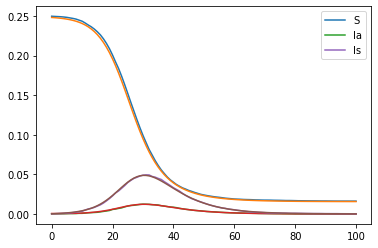

In [22]:
params = np.load('SIR_param2.npy')
parameters = {'alpha':params[0], 'beta':params[1], 'gIa':params[2], 'gIs':params[3],'fsa':0.8}
print(parameters)
estimator.set_params(parameters)
x0 = params[4:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

guessed initial conditons:  [12402 37465    26     5     6    11]
true initial conditions:  [12480. 37480.] [10 10] [10 10]


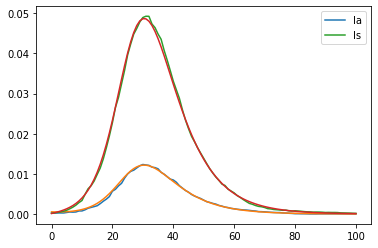

In [21]:
# replot the infected 
print('guessed initial conditons: ', (params[4:]*N).astype('int'))
print('true initial conditions: ', S0, Ia0, Is0)
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

## Inference with part of the trajectory 

In [24]:
# Cut the observed data 
Tf = 20 
Nf = Tf+1 
obs = obs[:Nf]

start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-75.80070646482098
0.21137309074401855


In [25]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-4 # step used to calculate hessian in the optimisation algorithm 

alpha_g = 0.25 # better guess for alpha 
alpha_bounds = (0.15, 0.3) # better bounds on alpha 
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.07
beta_bounds = (eps, 0.1)

gIa_g = 0.145
gIa_bounds = (0.13, 0.15) # better bounds on gIa 

gIs_g = 0.145
gIs_bounds = (0.13, 0.15) 

fsa_g = 0.8

S0_g = S0/N
Ia0_g = Ia0/N

# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)  

# set up bounds for Ia and S 
bounds_for_Ia = [(0.1/N, 100/N)]*M
bounds_for_Is = [(6/N, 14/N)]*M 
bounds_for_S = [(fi[i]-100/N-Is0[i]/N, fi[i]-0.1/N) for i in range(M)]

# set up bounds for the rest of the params 
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0])
params = estimator.latent_inference(guess, obs, fltr, Tf, Nf, contactMatrix, 
                                    bounds, verbose=True, niter=2, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here 

parameters: [0.28302277 0.02383417 0.14830228 0.14830228]
parameters: [0.28378851 0.02175089 0.14837089 0.14799285]
parameters: [0.28428147 0.0197578  0.14843751 0.14778622]
parameters: [0.28389751 0.02030122 0.14843654 0.14794518]
parameters: [0.28339975 0.020399   0.14846308 0.14813628]
parameters: [0.28297416 0.02031947 0.14849423 0.14829258]
parameters: [0.28249584 0.02018626 0.14850889 0.14838328]
parameters: [0.28144932 0.02000095 0.14848857 0.14845445]
parameters: [0.28069345 0.0199698  0.1483469  0.14819973]
parameters: [0.28035546 0.0199373  0.14824136 0.14797274]
parameters: [0.28003417 0.01989532 0.14800119 0.14737978]
parameters: [0.27969355 0.01981384 0.14760867 0.14633006]
parameters: [0.27926504 0.01970628 0.14693536 0.14445806]
parameters: [0.27864478 0.01948693 0.14592205 0.14164447]
parameters: [0.27572579 0.01875071 0.14088428 0.13      ]
parameters: [0.27601522 0.01892402 0.14121714 0.13      ]
parameters: [0.27627891 0.01893039 0.141307   0.13      ]
parameters: [0

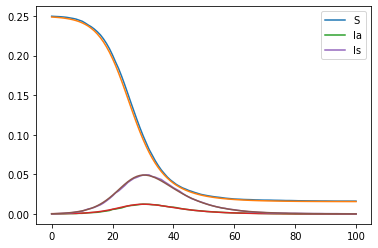

In [28]:
parameters = estimator.make_params_dict(params[:4])
estimator.set_params(parameters)
x0 = params[4:]
x_det = estimator.integrate(x0, 0, 100,101, det_model, contactMatrix)
plt.plot(x[:,0], label='S')
plt.plot(x_det[:, 0])
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

When only the first 20 points are used, the whole trajectory is still well predicted 